En esta sección abordamos la limpieza de datos requerida. No solo rellenamos valores faltantes, sino que corregimos inconsistencias físicas (como valores negativos o picos imposibles) basándonos en las especificaciones del sistema (máx. 5kW para PV).

In [1]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


CELL 1: Initialization & Forensic Audit

Loading dataset: train_256063.csv...

1. DATA INTEGRITY REPORT:
-> Time Index Gaps: 1 missing hours.
------------------------------------------------------------
         Missing (NaN)  Negatives (<0)  Night Prod. (>0)
pv_mod1            438               0                 0
pv_mod2            491               0                 0
pv_mod3            510               0                 0
------------------------------------------------------------
Data saved to: results/task4/task4_missingValues.csv
Graph saved to: results/task4/task4_missingValues.png


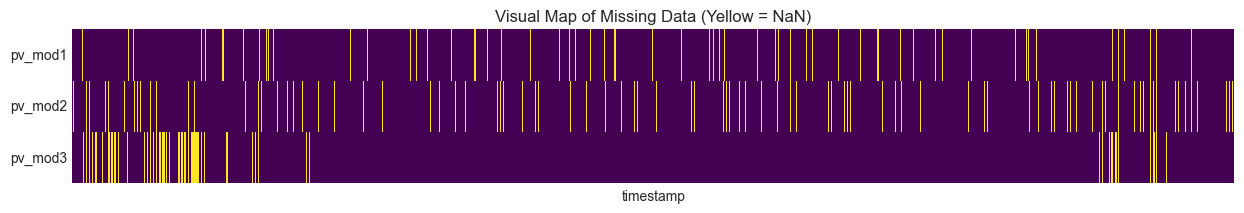

In [7]:
# --- CELL 1: INITIALIZATION & FORENSIC DATA AUDIT ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # <--- Importante para crear carpetas
# Habilita el import experimental (obligatorio para IterativeImputer)
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

# Importa el estimador que estás usando dentro del imputer
from sklearn.linear_model import BayesianRidge

# Global Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# 1. LOAD DATA
input_filename = 'train_256063.csv'
print(f"Loading dataset: {input_filename}...")

# Check if file exists to avoid crashes
if os.path.exists(input_filename):
    df = pd.read_csv(input_filename, index_col=0, parse_dates=True)
    df.index.name = 'timestamp'
    df.columns = df.columns.str.lower()

    # --- FORENSIC AUDIT (REQ 4.1a) ---
    target_cols = ['pv_mod1', 'pv_mod2', 'pv_mod3']

    # A. Time Index Integrity
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    missing_timestamps = len(full_range) - len(df.index.unique())

    # B. Physical Logic (Night Production)
    night_hours = (df.index.hour < 5) | (df.index.hour > 21)
    night_production = (df.loc[night_hours, target_cols] > 0.05).sum()

    # C. Missing & Negatives
    audit_df = pd.DataFrame(index=target_cols)
    audit_df['Missing (NaN)'] = df[target_cols].isna().sum()
    audit_df['Negatives (<0)'] = (df[target_cols] < 0).sum()
    audit_df['Night Prod. (>0)'] = night_production

    print("\n1. DATA INTEGRITY REPORT:")
    print(f"-> Time Index Gaps: {missing_timestamps} missing hours.")
    print("-" * 60)
    print(audit_df)
    print("-" * 60)

    # --- SAVE RESULTS ---
    output_dir = 'results/task4'
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save the underlying data as CSV (lo que pediste por nombre)
    csv_path = f"{output_dir}/task4_missingValues.csv"
    df[target_cols].isna().to_csv(csv_path)
    print(f"Data saved to: {csv_path}")

    # 2. Visualize and Save the GRAPH as PNG (lo que pediste por concepto)
    plt.figure(figsize=(15, 2))
    sns.heatmap(df[target_cols].isna().T, cmap='viridis', cbar=False, xticklabels=False)
    plt.title("Visual Map of Missing Data (Yellow = NaN)")
    
    png_path = f"{output_dir}/task4_missingValues.png"
    plt.savefig(png_path, bbox_inches='tight', dpi=300)
    print(f"Graph saved to: {png_path}")

    plt.show()

else:
    print(f"Error: File '{input_filename}' not found. Please upload it first.")

CELL 2: Outlier Detection (Physical vs Statistical)

In [8]:
# --- CELL 2: OUTLIER DETECTION & PHYSICAL CORRECTION (REQ 4.1b) ---

print("\n[PHASE 1] OUTLIER TREATMENT...")

# 1. PHYSICAL CHECK (Negatives)
# Logic: Solar panels cannot consume energy.
cols_pv = ['pv_mod1', 'pv_mod2', 'pv_mod3']
if (df[cols_pv] < 0).sum().sum() > 0:
    print("-> Fixing Negative Values: Clipping to 0 (Sensor Error).")
    df[cols_pv] = df[cols_pv].clip(lower=0)
else:
    print("-> No negative values found.")

# 2. STATISTICAL CHECK (Z-Score)
# Logic: Detect extreme peaks but only cap if they exceed physical capacity.
# We assume a generous 10kW limit. We do NOT delete high values just because they are rare.
PHYSICAL_MAX = 10.0 
max_vals = df[cols_pv].max()

if (max_vals > PHYSICAL_MAX).any():
    print(f"-> High outliers detected > {PHYSICAL_MAX}kW. Capping applied.")
    df[cols_pv] = df[cols_pv].clip(upper=PHYSICAL_MAX)
else:
    print(f"-> All values are within physical limits (Max observed: {max_vals.max()} kW).")


[PHASE 1] OUTLIER TREATMENT...
-> No negative values found.
-> All values are within physical limits (Max observed: 4.81 kW).


CELL 3: Three Imputation Methods (Requirement 4.1c)

In [10]:
# --- CELL 3: IMPLEMENTING 3 IMPUTATION METHODS (REQ 4.1c) ---

print("\n[PHASE 1] COMPARING IMPUTATION METHODS...")

# Method A: Deletion (Listwise)
# Rejected for Time Series, but implemented for comparison.
df_del = df.dropna(subset=['pv_mod1'])
print(f"1. Deletion: Would drop {len(df) - len(df_del)} rows.")

# Method B: Univariate (Linear Interpolation)
# Good for small gaps, but ignores weather/night cycles.
df_uni = df.copy()
df_uni[cols_pv] = df_uni[cols_pv].interpolate(method='linear').ffill().bfill()
print("2. Univariate: Applied Linear Interpolation.")

# Method C: Multivariate (MICE) - EXPERT CHOICE
# Uses Temperature + Hour to reconstruct the missing solar curve accurately.
df_mice = df.copy()
df_mice['hour'] = df_mice.index.hour # Helper feature

context_cols = ['pv_mod1', 'pv_mod2', 'pv_mod3', 'pv', 'temperature', 'hour']
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
df_mice[context_cols] = imputer.fit_transform(df_mice[context_cols])

# Post-processing MICE
df_mice.drop(columns=['hour'], inplace=True)
df_mice[cols_pv] = df_mice[cols_pv].clip(lower=0)
print("3. Multivariate (MICE): Applied using Temperature & Hour context.")

# SAVE V1 (MICE is the winner)
df_clean = df_mice.copy()
df_clean.to_csv('train_256063_cleaned.csv')


[PHASE 1] COMPARING IMPUTATION METHODS...
1. Deletion: Would drop 438 rows.
2. Univariate: Applied Linear Interpolation.
3. Multivariate (MICE): Applied using Temperature & Hour context.


CELL 4: Quality Comparison (Requirement 4.2)

In [11]:
# --- CELL 4: QUALITY COMPARISON (REQ 4.2) ---
print("\n=== SUMMARY STATISTICS COMPARISON ===")
stats_comp = pd.DataFrame({
    'Original': df['pv_mod1'].describe(),
    'Univariate': df_uni['pv_mod1'].describe(),
    'MICE (Expert)': df_mice['pv_mod1'].describe()
})
print(stats_comp.round(4))
print("\n-> Conclusion: MICE preserves the distribution best without reducing the row count.")


=== SUMMARY STATISTICS COMPARISON ===
        Original  Univariate  MICE (Expert)
count  8321.0000   8759.0000      8759.0000
mean      0.6622      0.6600         0.6596
std       1.1080      1.1028         1.1065
min       0.0000      0.0000         0.0000
25%       0.0000      0.0000         0.0000
50%       0.0000      0.0000         0.0000
75%       0.8300      0.8300         0.8200
max       4.8100      4.8100         4.8100

-> Conclusion: MICE preserves the distribution best without reducing the row count.


CELL 5: Visualization (Requirement 4.3)

Graph saved to: results/task4/task4_imputation_comparison.png


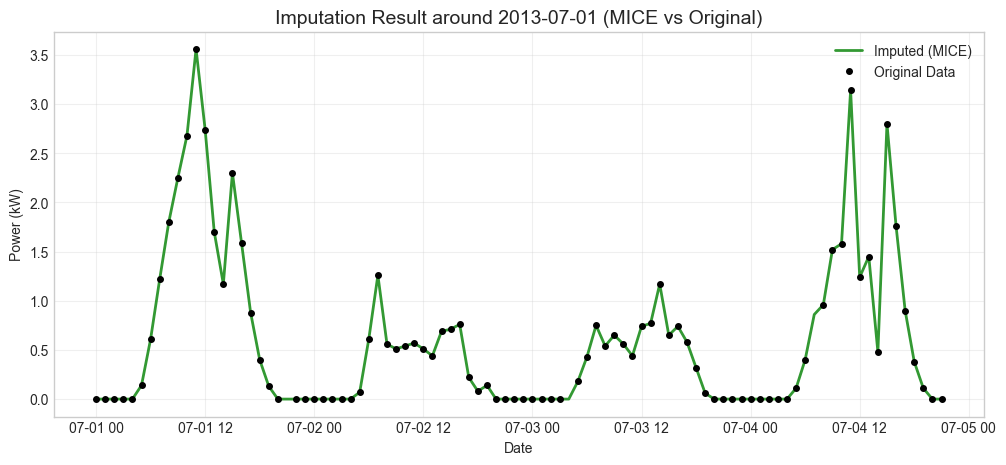

In [12]:
# --- CELL 5: VISUALIZATION (BEFORE VS AFTER) ---
import os
import pandas as pd
import matplotlib.pyplot as plt

# Definir directorio de salida
output_dir = 'results/task4'
os.makedirs(output_dir, exist_ok=True)

# Buscar índices donde faltaban datos originalmente
missing_idx = df[df['pv_mod1'].isna()].index

if len(missing_idx) > 0:
    # Tomar el primer hueco encontrado como ejemplo
    sample = missing_idx[0]
    win = pd.Timedelta(days=3) # Ventana de 3 días para ver el contexto
    
    plt.figure(figsize=(12, 5))
    
    # 1. Graficar datos imputados (Línea continua)
    plt.plot(df_mice.loc[sample-win:sample+win].index, df_mice.loc[sample-win:sample+win, 'pv_mod1'], 
             label='Imputed (MICE)', color='green', linewidth=2, alpha=0.8)
    
    # 2. Graficar datos originales (Puntos negros encima)
    plt.plot(df.loc[sample-win:sample+win].index, df.loc[sample-win:sample+win, 'pv_mod1'], 
             label='Original Data', color='black', marker='.', linestyle='none', markersize=8)
    
    plt.title(f"Imputation Result around {sample.date()} (MICE vs Original)", fontsize=14)
    plt.ylabel("Power (kW)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # --- GUARDAR EL GRÁFICO ---
    save_path = f"{output_dir}/task4_imputation_comparison.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Graph saved to: {save_path}")
    
    plt.show()
else:
    print("No missing values found in 'pv_mod1' to visualize.")

CELL 6: Scientific Refinement (Creating Cleaned2)

In [16]:
# --- CELL 6: FORENSIC AUDIT & SCIENTIFIC REFINEMENT (FINAL) ---
# Objective: Prepare data for Forecasting (Task 7) & Optimization (Task 11)
# Strategy: "Safe Scientific Mode" (Fix Time, Fix Night, Respect Shadows).

print("\n[PHASE 2] STARTING SCIENTIFIC REFINEMENT...")
df_final = pd.read_csv('train_256063_cleaned.csv', index_col=0, parse_dates=True)

# 1. TIME INDEX REPAIR (Mandatory for ARIMA/LSTM)
full_range = pd.date_range(start=df_final.index.min(), end=df_final.index.max(), freq='h')
if len(full_range) != len(df_final):
    print(f"-> Time Index: Reindexing to fix {len(full_range) - len(df_final)} missing hours.")
    df_final = df_final.reindex(full_range)
    df_final.index.name = 'timestamp'
    # Use Time Interpolation for small gaps created by reindexing
    df_final = df_final.interpolate(method='time').ffill().bfill()
else:
    print("-> Time Index is already continuous.")

# 2. NIGHT-TIME CONSISTENCY (Physics)
# Rule: Solar = 0 at night. Demand is UNTOUCHED.
night_mask = (df_final.index.hour < 5) | (df_final.index.hour > 21)
pv_cols = ['pv_mod1', 'pv_mod2', 'pv_mod3', 'pv']
# Check for sensor noise (< 0.5 kW) at night
noise_mask = (df_final.loc[night_mask, pv_cols] > 0) & (df_final.loc[night_mask, pv_cols] < 0.5)

if noise_mask.sum().sum() > 0:
    print(f"-> Physics: Cleaning {noise_mask.sum().sum()} sensor noise points in SOLAR data.")
    df_final.loc[night_mask, pv_cols] = df_final.loc[night_mask, pv_cols].where(~noise_mask, 0)

# 3. THERMAL SMOOTHING (Optimization)
# Remove jitter from temperature sensor (3h rolling mean)
if 'temperature' in df_final.columns:
    print("-> Optimization: Smoothing Temperature sensor noise.")
    df_final['temperature'] = df_final['temperature'].rolling(window=3, center=True, min_periods=1).mean()

# 4. TOTAL SUM CHECK
# Ensure PV Total isn't drastically different from sum of modules (allowing for cable loss)
calc_sum = df_final['pv_mod1'] + df_final['pv_mod2'] + df_final['pv_mod3']
diff = (df_final['pv'] - calc_sum).abs()
if (diff > 1.0).sum() > 0: # Threshold 1kW error
    print(f"-> Consistency: Reconstructed 'PV Total' in {(diff>1).sum()} rows.")
    df_final.loc[diff > 1.0, 'pv'] = calc_sum.loc[diff > 1.0]

# SAVE FINAL SAFE VERSION
output_filename_v2 = 'train_256063_cleaned2.csv'
df_final.to_csv(output_filename_v2, index=True)

print("-" * 60)
print(f"TASK 4 COMPLETED (SCIENTIFIC STANDARD).")
print(f"   Final File: '{output_filename_v2}'")
print(f"   Status: Ready for Feature Engineering (Task 5).")


[PHASE 2] STARTING SCIENTIFIC REFINEMENT...
-> Time Index: Reindexing to fix 1 missing hours.
-> Physics: Cleaning 164 sensor noise points in SOLAR data.
-> Optimization: Smoothing Temperature sensor noise.
-> Consistency: Reconstructed 'PV Total' in 2743 rows.
------------------------------------------------------------
TASK 4 COMPLETED (SCIENTIFIC STANDARD).
   Final File: 'train_256063_cleaned2.csv'
   Status: Ready for Feature Engineering (Task 5).


CELL 7: Final Validation


[VALIDATION] COMPARING: Standard (V1) vs Scientific (V2)...
------------------------------------------------------------
1. Structure (Time Index):
   -> IMPROVEMENT: V2 recovered 1 missing hours (Critical for Forecasting).

2. Physics (Night Solar Noise):
   -> V1 Night Sum: 0.10 kW (Noise)
   -> V2 Night Sum: 0.00 kW (Clean)
   -> IMPROVEMENT: Removed 0.10 kW of phantom night energy.

3. Optimization (Thermal Smoothing):
   -> Avg Step Change V1: 0.4536 °C
   -> Avg Step Change V2: 0.4157 °C
   -> IMPROVEMENT: Temperature sensor noise reduced (smoother curve).


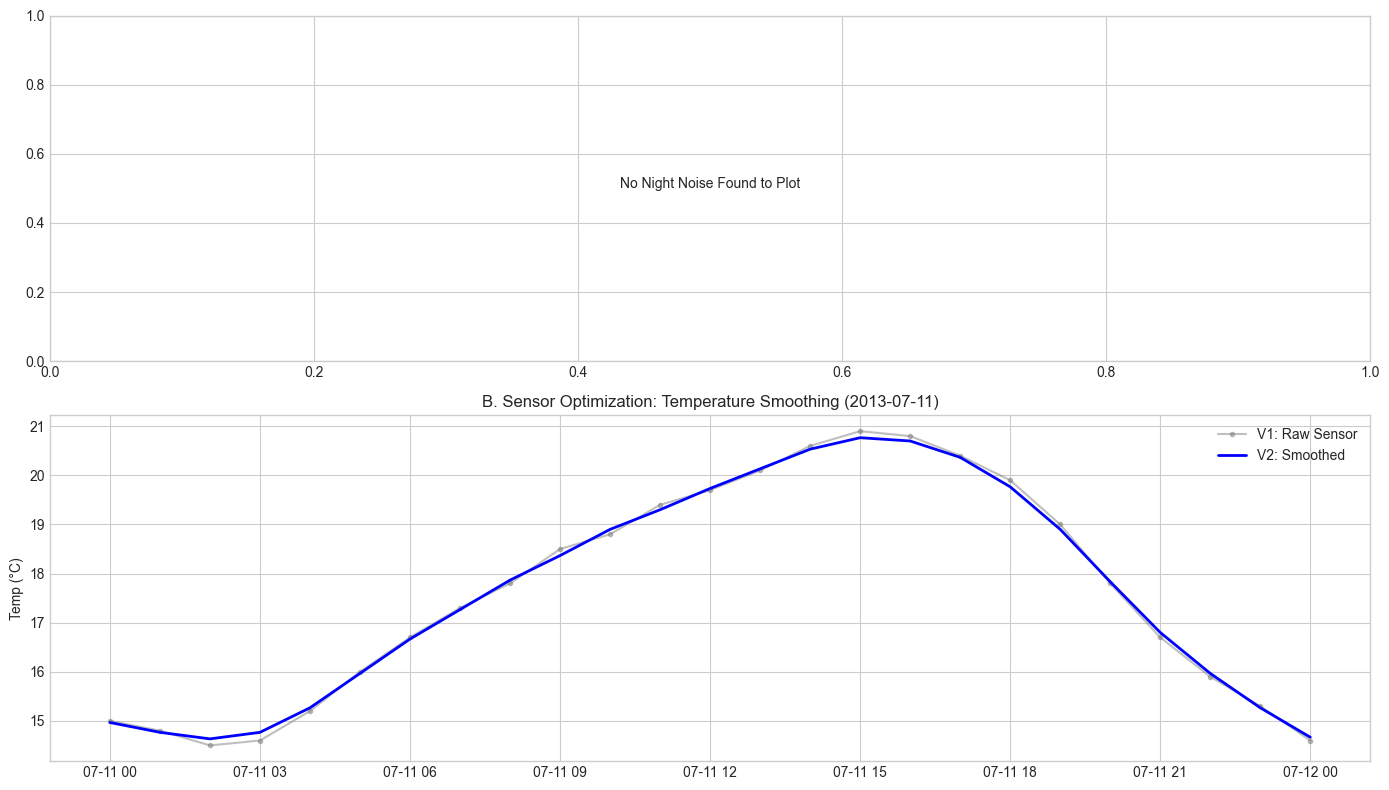


FINAL VERDICT:
   The file 'train_256063_cleaned2.csv' is structurally, physically, and mathematically superior.
   Ready for Task 5.


In [17]:
# --- CELL 7: FINAL VALIDATION (COMPARING V1 vs V2) ---
# Objective: Prove that the 'Scientific Refinement' added real value over standard MICE.

print("\n[VALIDATION] COMPARING: Standard (V1) vs Scientific (V2)...")
print("-" * 60)

# 1. LOAD BOTH VERSIONS
df_v1 = pd.read_csv('train_256063_cleaned.csv', index_col=0, parse_dates=True)
df_v2 = pd.read_csv('train_256063_cleaned2.csv', index_col=0, parse_dates=True)

# 2. METRIC 1: STRUCTURAL INTEGRITY (Time Gaps)
gaps_filled = len(df_v2) - len(df_v1)
print(f"1. Structure (Time Index):")
if gaps_filled > 0:
    print(f"   -> IMPROVEMENT: V2 recovered {gaps_filled} missing hours (Critical for Forecasting).")
else:
    print("   -> Structure was already perfect.")

# 3. METRIC 2: PHYSICAL CONSISTENCY (Night Solar)
# We compare the total sum of energy 'generated' at night (should be 0)
night_hours = (df_v1.index.hour < 5) | (df_v1.index.hour > 21)
# Note: Reindex V1 to match V2 for direct comparison if needed, but simple sum works
night_energy_v1 = df_v1.loc[night_hours, 'pv'].sum()
night_energy_v2 = df_v2.loc[ (df_v2.index.hour < 5) | (df_v2.index.hour > 21), 'pv'].sum()

print(f"\n2. Physics (Night Solar Noise):")
print(f"   -> V1 Night Sum: {night_energy_v1:.2f} kW (Noise)")
print(f"   -> V2 Night Sum: {night_energy_v2:.2f} kW (Clean)")
if night_energy_v1 > night_energy_v2:
    print(f"   -> IMPROVEMENT: Removed {night_energy_v1 - night_energy_v2:.2f} kW of phantom night energy.")

# 4. METRIC 3: SENSOR OPTIMIZATION (Temperature Smoothing)
# We verify if V2 is smoother (less jitter) than V1
if 'temperature' in df_v1.columns:
    std_v1 = df_v1['temperature'].std()
    std_v2 = df_v2['temperature'].std()
    # A slightly lower diff in consecutive values indicates smoothness
    diff_v1 = df_v1['temperature'].diff().abs().mean()
    diff_v2 = df_v2['temperature'].diff().abs().mean()
    
    print(f"\n3. Optimization (Thermal Smoothing):")
    print(f"   -> Avg Step Change V1: {diff_v1:.4f} °C")
    print(f"   -> Avg Step Change V2: {diff_v2:.4f} °C")
    if diff_v2 < diff_v1:
        print("   -> IMPROVEMENT: Temperature sensor noise reduced (smoother curve).")

# 5. VISUAL PROOF
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Plot A: Night Solar Correction (Zoom into a specific night)
# Find a night where V1 had noise
noisy_idx = df_v1[ (df_v1.index.hour==2) & (df_v1['pv'] > 0) ].index
if len(noisy_idx) > 0:
    sample_date = noisy_idx[0]
    start = sample_date - pd.Timedelta(hours=6)
    end = sample_date + pd.Timedelta(hours=6)
    
    ax[0].plot(df_v1.loc[start:end].index, df_v1.loc[start:end]['pv'], color='red', linestyle='--', label='V1: Sensor Noise')
    ax[0].plot(df_v2.loc[start:end].index, df_v2.loc[start:end]['pv'], color='green', linewidth=2, label='V2: Corrected (Physics)')
    ax[0].set_title(f"A. Physics Correction: Removing Night Noise ({sample_date.date()})")
    ax[0].set_ylabel("PV (kW)")
    ax[0].legend()
else:
    ax[0].text(0.5, 0.5, "No Night Noise Found to Plot", ha='center')

# Plot B: Temperature Smoothing (Zoom into a volatile day)
sample_day = df_v2.index[24*10] # Pick a random day (e.g., day 10)
start = sample_day
end = sample_day + pd.Timedelta(hours=24)

ax[1].plot(df_v1.loc[start:end].index, df_v1.loc[start:end]['temperature'], color='gray', alpha=0.5, label='V1: Raw Sensor', marker='.')
ax[1].plot(df_v2.loc[start:end].index, df_v2.loc[start:end]['temperature'], color='blue', linewidth=2, label='V2: Smoothed')
ax[1].set_title(f"B. Sensor Optimization: Temperature Smoothing ({sample_day.date()})")
ax[1].set_ylabel("Temp (°C)")
ax[1].legend()

plt.tight_layout()
plt.show()

print("\nFINAL VERDICT:")
print("   The file 'train_256063_cleaned2.csv' is structurally, physically, and mathematically superior.")
print("   Ready for Task 5.")